Animal Detection and 3D Pose-Based Viewpoint Estimation
This notebook tests the new animal detection and 3D pose-based viewpoint estimation pipeline using labeled clusters from the interactive annotation tool.
## Pipeline Overview
1. **Load labeled clusters** from JSON (created via cluster_labeler.py)
2. **Animal detection** using morphological processing of labeled clusters
3. **3D pose estimation** from body part centroids
4. **Viewpoint classification** from 3D orientation angles
5. **Performance evaluation** against ground truth

## 1. Setup and Data Loading

In [2]:
%load_ext autoreload
%autoreload 2

# Enable interactive matplotlib for 3D visualization
%matplotlib widget

from pathlib import Path
import sys
sys.path.append(str(Path("..")))

# Import required modules
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
from PIL import Image
from typing import Dict, List

# Import project modules
from src.utils.config import load_config
from src.data.cvat_loader import CVATLoader
from src.data.coco_loader import COCOLoader
from src.models.dinov2_extractor import DINOv2PatchExtractor, aggregate_depth_to_patches
from src.utils.analysis_utils import load_analysis_model

# Import detection modules
from src.detection.animal_detector import (
    detect_animals_from_clusters, 
    evaluate_animal_detection
)

# Import new 3D viewpoint estimation modules
from src.classification.viewpoint_3d import estimate_viewpoint_with_axis_fitting
from src.visualization.cluster_visualization import create_viewpoint_visualization, create_3d_axes_visualization
from src.visualization.depth_visualization import create_depth_visualization, create_3d_depth_surface
from src.visualization.detection_visualization import plot_animal_detections

# Set up matplotlib
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("All modules imported successfully!")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
All modules imported successfully!


In [3]:
# Load configuration
# config = load_config(Path("../config.yaml"))
config = load_config(Path("../config_zebra_test.yaml"))
print(f"Configuration loaded from config.yaml")
print(f"Dataset: {config['dataset']['root_path']}")
print(f"Analysis method: {config['analysis']['method']}")

dataset_config = config['dataset']
dataset_root = ".."/Path(dataset_config['root_path'])
crop_to_bbox = dataset_config.get('crop_to_bbox', True)
dataset_format = dataset_config.get('format', 'cvat')  # Default to CVAT for backward compatibility

# Use images_dir to override root_path if provided
if 'images_dir' in dataset_config and dataset_config['images_dir']:
    image_root = Path(dataset_config['images_dir'])
    if not image_root.is_absolute():
        image_root = dataset_root / dataset_config['images_dir']
else:
    image_root = dataset_root

if dataset_format.lower() == 'coco':
    annotations_file = dataset_config['annotations_file']
    coco_json_path = dataset_root / annotations_file
    loader = COCOLoader(image_root, coco_json_path, crop_to_bbox=crop_to_bbox)
    print(f"Loaded COCO dataset: {len(loader)} annotations")
    print(f"Annotations from: {coco_json_path}")
    print(f"Images from: {image_root}")
elif dataset_format.lower() == 'cvat':
    loader = CVATLoader(dataset_root, crop_to_bbox=crop_to_bbox)
    print(f"Loaded CVAT dataset: {len(loader)} annotations")
    print(f"Dataset root: {dataset_root}")
annotations = loader.annotations.copy()

print(f"\nDataset loaded:")
print(f"  Total images: {len(annotations)}")
print(f"  Crop to bbox: {crop_to_bbox}")

# Show viewpoint distribution
viewpoints = [ann.viewpoint for ann in annotations]
unique_viewpoints, counts = np.unique(viewpoints, return_counts=True)
print(f"\nViewpoint distribution:")
for vp, count in zip(unique_viewpoints, counts):
    print(f"  {vp}: {count} images")

Configuration loaded from config.yaml
Dataset: zebra
Analysis method: kmeans
Loaded COCO dataset: 19148 annotations
Annotations from: ../zebra/GZCD_Cleaned.json
Images from: ../zebra/images

Dataset loaded:
  Total images: 19148
  Crop to bbox: False

Viewpoint distribution:
  back: 290 images
  backleft: 167 images
  backright: 1377 images
  downbackright: 4 images
  downleft: 2 images
  downright: 18 images
  front: 114 images
  frontleft: 118 images
  frontright: 405 images
  ignore: 5644 images
  left: 649 images
  right: 10312 images
  unknown: 3 images
  upbackleft: 3 images
  upbackright: 11 images
  upfrontleft: 2 images
  upfrontright: 2 images
  upleft: 4 images
  upright: 23 images


In [16]:
# Initialize feature extractor
model_config = config['model']
extractor = DINOv2PatchExtractor(
    model_name=model_config['dinov2_model'],
    device=model_config['device'],
    image_size=model_config['image_size'],
)

print(f"DINOv2 extractor initialized:")
print(f"  Model: {model_config['dinov2_model']}")
print(f"  Device: {model_config['device']}")
print(f"  Image size: {model_config['image_size']}")

# Load analysis model
analysis_config = config['analysis']
model_path = Path(analysis_config['output_dir']) / analysis_config['model_filename']
analysis_method = load_analysis_model(Path("..") / model_path)
n_clusters = analysis_method.get_n_components()
relative_patch_size = model_config['patch_size'] / model_config['image_size']

print(model_path)
print(f"\nAnalysis model loaded:")
print(f"  Method: {analysis_method.get_method_name()}")
print(f"  Components: {n_clusters}")
print(f"  Relative patch size: {relative_patch_size:.4f}")

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


DINOv2 extractor initialized:
  Model: dinov2_vits14_ld
  Device: cuda
  Image size: 518
outputs_zebra/analysis/zebra_test_kmeans10.npz

Analysis model loaded:
  Method: MiniBatch K-Means (30 clusters)
  Components: 30
  Relative patch size: 0.0270


## 2. Load Labeled Clusters

Load the cluster labels created using the interactive annotation tool (`cluster_labeler.py`).

In [17]:
# Load cluster labels from JSON file
# NOTE: This file should be created using cluster_labeler.py
labels_file = Path("../cluster_labels.json")

with open(labels_file, 'r') as f:
    cluster_labels = json.load(f)
    print(f"Cluster labels loaded from {labels_file}")

print("\nCluster label assignments:")
for label, clusters in cluster_labels.items():
    print(f"  {label}: clusters {clusters}")

# Identify animal vs background clusters
background_labels = ["background", "vegetation", "ground", "shadow"]
animal_labels = [label for label in cluster_labels.keys() if label not in background_labels]

print(f"\nAnimal body parts: {animal_labels}")
print(f"Background elements: {[label for label in cluster_labels.keys() if label in background_labels]}")

Cluster labels loaded from ../cluster_labels.json

Cluster label assignments:
  neck: clusters [3]
  legs: clusters [4, 27]
  background: clusters [0, 1, 2, 5, 6, 7, 8, 11, 13, 14, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 28]
  tail: clusters [9]
  belly: clusters [10]
  back: clusters [12]
  head: clusters [15]
  other: clusters [20]
  body: clusters [29]

Animal body parts: ['neck', 'legs', 'tail', 'belly', 'back', 'head', 'other', 'body']
Background elements: ['background']


## 3. Animal Detection Testing

Test animal detection using labeled clusters with morphological cleanup.

In [18]:
# Test animal detection on a sample of images
test_indices = [0, 5, 10, 15, 20]  # Sample image indices
test_indices = [20, 25, 210, 215, 220]
detection_results = []

print("Testing animal detection on sample images...")

for i, idx in enumerate(test_indices):
    if idx >= len(annotations):
        continue
        
    annotation = annotations[idx]
    # img_id = annotation.image_path.name
    img_id = annotation.annot_uuid
    print(f"\nProcessing image {idx}: {img_id}")
    
    # Load and process image - USE CORRECT relative_patch_size from extractor
    image = loader.load_image(annotation)
    patch_features, patch_coordinates, actual_relative_patch_size = extractor.extract_patch_features(image)
    
    # Transform with analysis method
    raw_output = analysis_method.transform(patch_features)
    if raw_output.ndim == 1:
        # Convert labels to one-hot encoding
        patch_components = np.zeros((len(raw_output), n_clusters))
        patch_components[np.arange(len(raw_output)), raw_output] = 1.0
    else:
        patch_components = raw_output
    
    # Detect animals - USE CORRECT relative_patch_size from extractor
    detections = detect_animals_from_clusters(
        patch_components,
        patch_coordinates,
        cluster_labels,
        actual_relative_patch_size,  # Use the CORRECT value from extractor
        background_labels=background_labels,
        kernel_size=1
    )
    
    print(f"  Found {len(detections)} animal detections")
    for j, detection in enumerate(detections):
        print(f"    Detection {j+1}: confidence={detection.confidence:.3f}, area_ratio={detection.area_ratio:.4f}")
    
    # Evaluate against ground truth - NOW WITH IMAGE SIZE
    # evaluation = evaluate_animal_detection(
    #     detections, annotation.bbox, image_size=image.size, iou_threshold=0.5
    # )
    evaluation={}
    
    detection_results.append({
        'annotation': annotation,
        'image': image,
        'detections': detections,
        'evaluation': evaluation
    })
    
    # print(f"  Evaluation: IoU={evaluation['best_iou']:.3f}, TP={evaluation['true_positive']}")
    

print(f"\nDetection testing completed on {len(detection_results)} images")

Testing animal detection on sample images...

Processing image 20: 1dc6b7fa-202b-49b0-b68f-de9403ed8c62
  Found 1 animal detections
    Detection 1: confidence=1.000, area_ratio=0.3457

Processing image 25: 7dfde41f-8491-45c0-9734-3965d6f30d8a
  Found 1 animal detections
    Detection 1: confidence=1.000, area_ratio=0.4923

Processing image 210: cd5b08da-87d0-4b76-ad45-6fd8f7e6ba9f
  Found 1 animal detections
    Detection 1: confidence=1.000, area_ratio=0.6849

Processing image 215: a66ebc29-af32-4511-b6df-83932089ff53
  Found 1 animal detections
    Detection 1: confidence=1.000, area_ratio=0.3980

Processing image 220: 0dbaeaf4-fc1f-4126-86a0-edc54152483b
  Found 1 animal detections
    Detection 1: confidence=1.000, area_ratio=0.8151

Detection testing completed on 5 images


### Animal Detection Visualization

Visualize the detection results with bounding boxes overlaid on original images.

Visualizing animal detection results...

Showing detections for: a66ebc29-af32-4511-b6df-83932089ff53


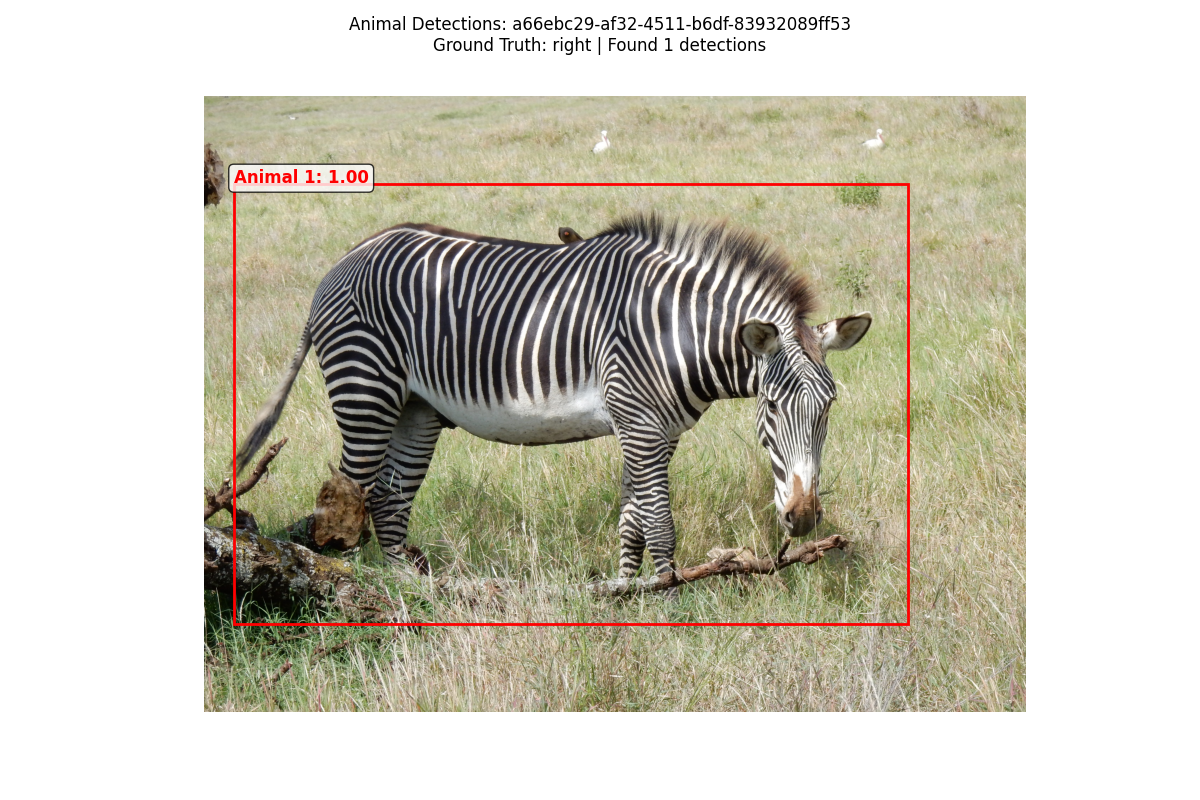

  Detection details:
    Detection 1: confidence=1.000
      BBox: (0.036, 0.143) to (0.857, 0.857)
      Area ratio: 0.3980
      Centroid: (12.0, 12.7)
Detection visualization complete!


In [19]:
# Visualize detection results
print("Visualizing animal detection results...")

# Show detection plots for successful cases
for i, result in enumerate(detection_results[3:4]):  # Show first 3 results
    annotation = result['annotation']
    image = result['image']
    detections = result['detections']
    
    if detections:  # Only show if we have detections
        # img_id = annotation.image_path.name
        img_id = annotation.annot_uuid
        print(f"\nShowing detections for: {img_id}")
        
        # Plot detections on original image
        detection_fig = plot_animal_detections(image, detections)
        detection_fig.suptitle(f"Animal Detections: {img_id}\n"
                              f"Ground Truth: {annotation.viewpoint} | "
                              f"Found {len(detections)} detections")
        plt.show()
        
        # Show detection details
        print(f"  Detection details:")
        for j, detection in enumerate(detections):
            bbox = detection.bbox
            print(f"    Detection {j+1}: confidence={detection.confidence:.3f}")
            print(f"      BBox: ({bbox.x1:.3f}, {bbox.y1:.3f}) to ({bbox.x2:.3f}, {bbox.y2:.3f})")
            print(f"      Area ratio: {detection.area_ratio:.4f}")
            print(f"      Centroid: ({detection.centroid[0]:.1f}, {detection.centroid[1]:.1f})")
    else:
        print(f"No detections found for: {annotation.image_path.name}")

print("Detection visualization complete!")

## 4. 3D Pose-Based Viewpoint Estimation

Test the new 3D pose estimation approach for viewpoint classification.

## 5. Depth-Enhanced 3D Pose Estimation

Test the new depth-enhanced 3D pose estimation using DINOv2's pre-trained depth heads.

In [10]:
# Initialize DINOv2 extractor with depth estimation enabled
print("Initializing DINOv2 extractor with depth estimation...")

depth_extractor = DINOv2PatchExtractor(
    model_name=model_config['dinov2_model'],
    device=model_config['device'],
    image_size=model_config['image_size'],
    enable_depth=True,
    depth_dataset="nyu"  # Use NYU dataset for indoor/general scenes
)

print(f"Depth-enabled extractor initialized:")
print(f"  Depth estimation: {depth_extractor.enable_depth}")

# Test depth extraction on first image
test_result = detection_results[1]
test_image = test_result['image']
annotation = test_result['annotation']

print(f"\nTesting depth extraction on: {annotation}")

# try:
# Extract features with depth
patch_features, patch_coordinates, actual_relative_patch_size, depthmap = depth_extractor.extract_patch_features_with_depth(test_image)

print(f"Depth extraction successful:")
print(f"  Patch features: {patch_features.shape}")
print(f"  Patch coordinates: {patch_coordinates.shape}")
print(f"  Patch depths: {depthmap.shape if depthmap is not None else 'None'}")

if depthmap is not None:
    print(f"  Depth range: {depthmap.min():.3f} to {depthmap.max():.3f}")
    print(f"  Mean depth: {depthmap.mean():.3f} ± {depthmap.std():.3f}")
    patch_depths = aggregate_depth_to_patches(depthmap, patch_coordinates, actual_relative_patch_size)

# except Exception as e:
#     print(f"Error during depth extraction: {e}")
#     import traceback
#     traceback.print_exc()

Initializing DINOv2 extractor with depth estimation...


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Depth-enabled extractor initialized:
  Depth estimation: True

Testing depth extraction on: COCOAnnotation(annot_uuid='7dfde41f-8491-45c0-9734-3965d6f30d8a', image_uuid='22827c7b-53ec-e2a5-c7d8-9f73056b812f', bbox=BoundingBox(x1=3023.0, y1=262.0, x2=4604.0, y2=2475.0), viewpoint='backright', category='zebra_grevys', category_id=1, manual=True, census_annot=False)
Depth extraction successful:
  Patch features: (999, 384)
  Patch coordinates: (999, 2)
  Patch depths: (3456, 4608)
  Depth range: 10.085 to 36.322
  Mean depth: 17.726 ± 4.563


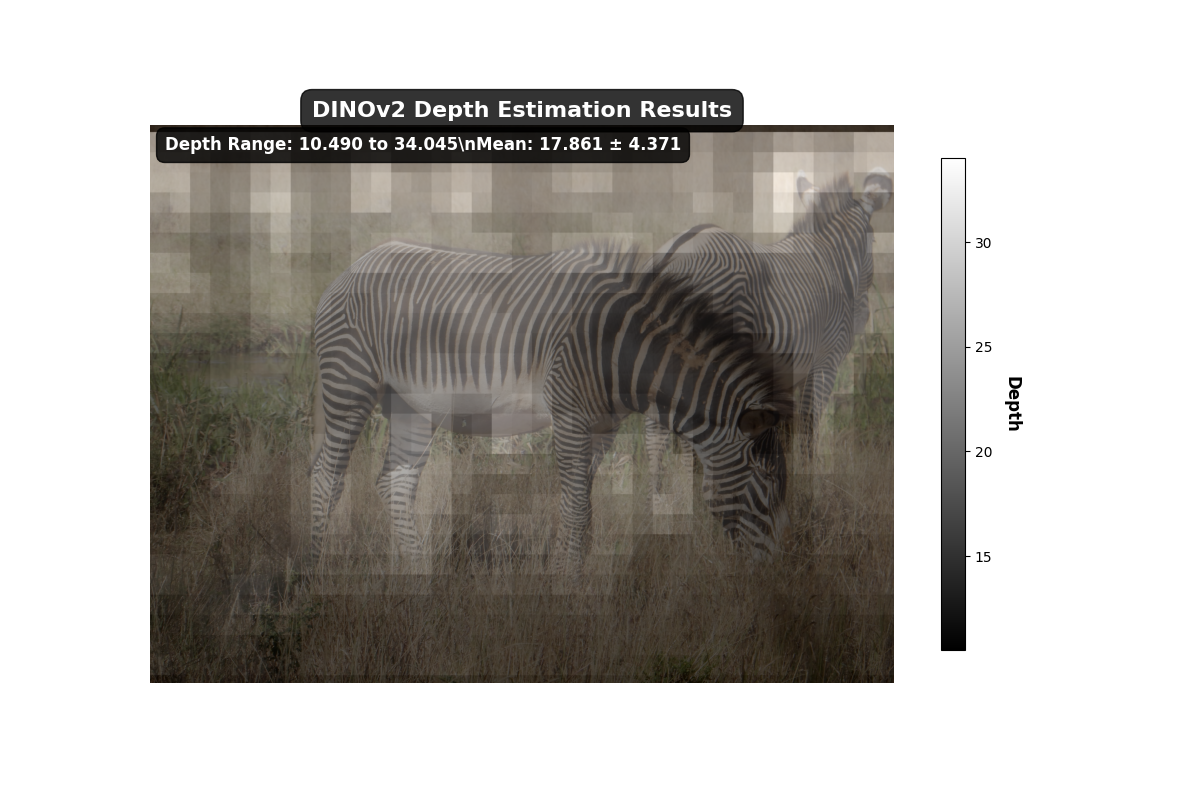

(4608, 3456)
(3456, 4608)


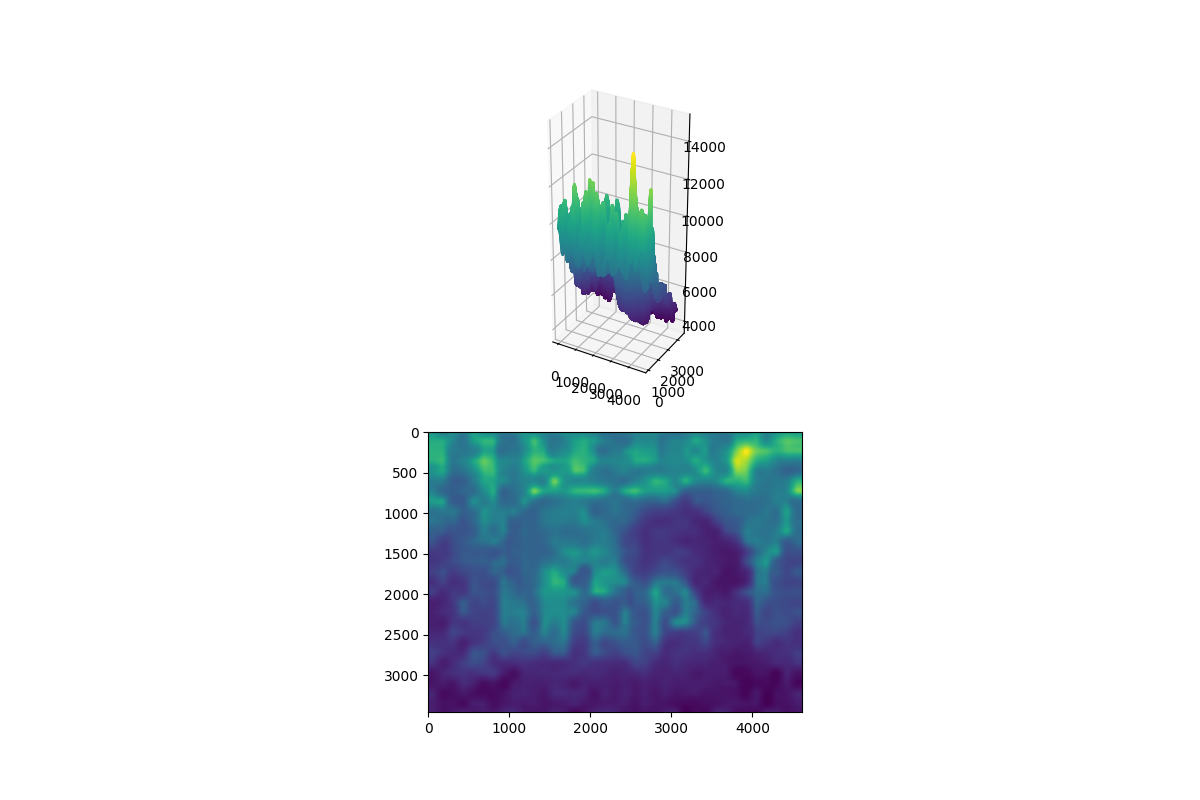

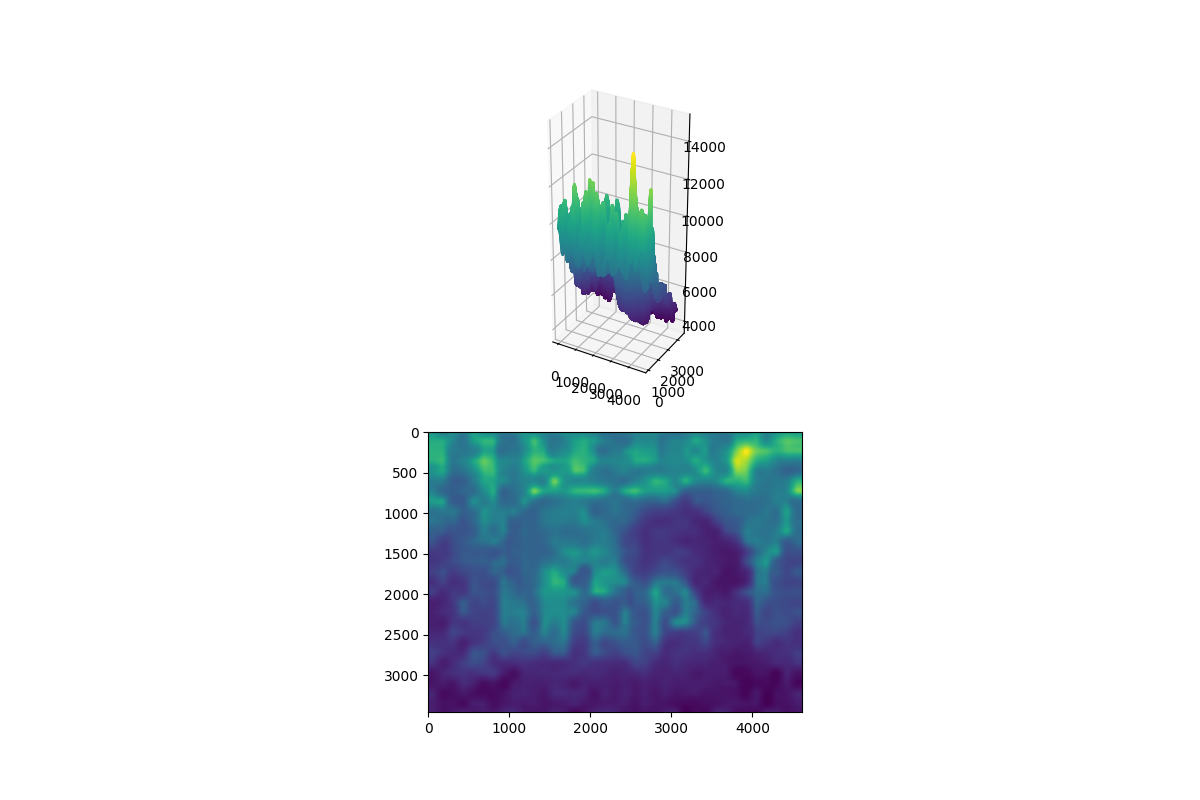

In [11]:
# from src.models.dinov2_extractor import DINOv2PatchExtractor, aggregate_depth_to_patches
# patch_depths = aggregate_depth_to_patches(depthmap, patch_coordinates, actual_relative_patch_size, 'median')
create_depth_visualization(
    test_image,
    patch_coordinates,
    patch_depths,
    actual_relative_patch_size,
    smooth = False,
    colormap = 'gray')
plt.show()
print(test_image.size)
print(depthmap.shape)
fig = plt.figure()
ax = fig.add_subplot(211, projection='3d')

X = np.arange(0, depthmap.shape[1])
Y = np.arange(0, depthmap.shape[0])
X, Y = np.meshgrid(X, Y)
# Create surface plot
# surface = ax.plot_surface(
#     X, Y, depthmap*np.mean(depthmap.shape), 
#     cmap="gray", alpha=0.9, 
#     linewidth=0, antialiased=True,
#     rasterized=True  # For better rendering performance
# )
flatdepth = depthmap.flatten()[::20]*np.mean(depthmap.shape)/10
ax.scatter(X.flatten()[::20], Y.flatten()[::20], flatdepth, s=1, c=flatdepth)
ax.set_aspect('equal')

ax = fig.add_subplot(212)
ax.imshow(depthmap)

fig.show()

In [ ]:

create_3d_depth_surface(test_image,
    patch_coordinates,
    patch_depths,
    37,
    show_original_points = False,
    invert_depth = False,
    colormap = 'gray')

In [13]:
# Test depth-enhanced 3D pose estimation on same sample images
depth_viewpoint_results = []

print("Testing depth-enhanced 3D pose estimation...")

for i, original_result in enumerate(detection_results):
    if not original_result['detections']:
        continue
        
    annotation = original_result['annotation']
    detection = original_result['detections'][0]
    
    print(f"\nDepth-enhanced estimation for image {i}: {annotation}")
    print(f"  Ground truth: {annotation.viewpoint}")
    
    try:
        # Extract features with depth
        image = original_result['image']
        patch_features, patch_coordinates, actual_relative_patch_size, depthmap = depth_extractor.extract_patch_features_with_depth(image)
        patch_depths = aggregate_depth_to_patches(depthmap, patch_coordinates, actual_relative_patch_size, 'median')
        # Transform with analysis method
        raw_output = analysis_method.transform(patch_features)
        if raw_output.ndim == 1:
            patch_components = np.zeros((len(raw_output), n_clusters))
            patch_components[np.arange(len(raw_output)), raw_output] = 1.0
        else:
            patch_components = raw_output
        
        # Estimate viewpoint using depth-enhanced 3D pose estimation
        depth_estimation_result = estimate_viewpoint_with_axis_fitting(
            patch_components,
            patch_coordinates,
            patch_depths,
            cluster_labels,
            image.size # Include depth information
        )
        
        print(f"  Depth-enhanced estimated: {depth_estimation_result['viewpoint']}")
        print(f"  Depth enabled: {depth_estimation_result.get('depth_enabled', False)}")
        print(f"  Confidence: {depth_estimation_result['confidence']:.3f}")
        print(f"  Available parts: {depth_estimation_result['available_parts']}")
        print(f"  Correct: {depth_estimation_result['viewpoint'] == annotation.viewpoint}")
        
        # Show depth information for body parts if available
        body_part_depths = depth_estimation_result.get('body_part_depths', {})
        if body_part_depths:
            print(f"  Body part depths:")
            for part, depth in body_part_depths.items():
                print(f"    {part}: {depth:.3f}")
        
        depth_viewpoint_results.append({
            'annotation': annotation,
            'estimation_result': depth_estimation_result,
            'correct': depth_estimation_result['viewpoint'] == annotation.viewpoint,
            # 'original_result': viewpoint_estimation_results[i] if i < len(viewpoint_estimation_results) else None
        })
        
    except Exception as e:
        print(f"  Error in depth-enhanced estimation: {e}")
        import traceback
        traceback.print_exc()
        continue

print(f"\nDepth-enhanced estimation completed on {len(depth_viewpoint_results)} images")

# Compare performance with and without depth
if depth_viewpoint_results:
    # original_accuracy = np.mean([r['correct'] for r in viewpoint_estimation_results])
    depth_accuracy = np.mean([r['correct'] for r in depth_viewpoint_results])
    
    print(f"\nPerformance Comparison:")
    # print(f"  Without depth: {original_accuracy:.3f} accuracy")
    print(f"  With depth: {depth_accuracy:.3f} accuracy")
    # print(f"  Improvement: {depth_accuracy - original_accuracy:+.3f}")
    
    # Show detailed comparison
    print(f"\nDetailed Comparison:")
    for i, (depth) in enumerate(depth_viewpoint_results):
        # orig_pred = orig['estimation_result']['viewpoint']
        depth_pred = depth['estimation_result']['viewpoint'] 
        gt = depth['annotation'].viewpoint
        
        print(f"  Image {i}: GT={gt}")
        # print(f"    Without depth: {orig_pred} ({'✓' if orig_pred == gt else '✗'})")
        print(f"    With depth:    {depth_pred} ({'✓' if depth_pred == gt else '✗'})")
        
        # if orig_pred != depth_pred:
        #     print(f"    → CHANGED prediction!")

Testing depth-enhanced 3D pose estimation...

Depth-enhanced estimation for image 0: COCOAnnotation(annot_uuid='1dc6b7fa-202b-49b0-b68f-de9403ed8c62', image_uuid='01c46c30-e30f-766a-8c9b-21aca77f0ba7', bbox=BoundingBox(x1=241.0, y1=542.0, x2=1903.0, y2=1313.0), viewpoint='right', category='zebra_grevys', category_id=1, manual=True, census_annot=False)
  Ground truth: right
  Error in depth-enhanced estimation: estimate_viewpoint_with_axis_fitting() missing 1 required positional argument: 'image_size'

Depth-enhanced estimation for image 1: COCOAnnotation(annot_uuid='7dfde41f-8491-45c0-9734-3965d6f30d8a', image_uuid='22827c7b-53ec-e2a5-c7d8-9f73056b812f', bbox=BoundingBox(x1=3023.0, y1=262.0, x2=4604.0, y2=2475.0), viewpoint='backright', category='zebra_grevys', category_id=1, manual=True, census_annot=False)
  Ground truth: backright


Traceback (most recent call last):
  File "/tmp/ipykernel_249560/1117389560.py", line 30, in <module>
    depth_estimation_result = estimate_viewpoint_with_axis_fitting(
TypeError: estimate_viewpoint_with_axis_fitting() missing 1 required positional argument: 'image_size'


  Error in depth-enhanced estimation: estimate_viewpoint_with_axis_fitting() missing 1 required positional argument: 'image_size'

Depth-enhanced estimation for image 2: COCOAnnotation(annot_uuid='cd5b08da-87d0-4b76-ad45-6fd8f7e6ba9f', image_uuid='9edbccb4-06a3-ac69-d903-5d0cab3fe4d4', bbox=BoundingBox(x1=0.0, y1=362.0, x2=1962.0, y2=1752.0), viewpoint='backright', category='zebra_grevys', category_id=1, manual=True, census_annot=False)
  Ground truth: backright


Traceback (most recent call last):
  File "/tmp/ipykernel_249560/1117389560.py", line 30, in <module>
    depth_estimation_result = estimate_viewpoint_with_axis_fitting(
TypeError: estimate_viewpoint_with_axis_fitting() missing 1 required positional argument: 'image_size'


  Error in depth-enhanced estimation: estimate_viewpoint_with_axis_fitting() missing 1 required positional argument: 'image_size'

Depth-enhanced estimation for image 3: COCOAnnotation(annot_uuid='a66ebc29-af32-4511-b6df-83932089ff53', image_uuid='4a3230f6-d6da-71d4-38af-be65fff7662d', bbox=BoundingBox(x1=137.0, y1=651.0, x2=3765.0, y2=2839.0), viewpoint='right', category='zebra_grevys', category_id=1, manual=True, census_annot=True)
  Ground truth: right


Traceback (most recent call last):
  File "/tmp/ipykernel_249560/1117389560.py", line 30, in <module>
    depth_estimation_result = estimate_viewpoint_with_axis_fitting(
TypeError: estimate_viewpoint_with_axis_fitting() missing 1 required positional argument: 'image_size'


  Error in depth-enhanced estimation: estimate_viewpoint_with_axis_fitting() missing 1 required positional argument: 'image_size'

Depth-enhanced estimation for image 4: COCOAnnotation(annot_uuid='0dbaeaf4-fc1f-4126-86a0-edc54152483b', image_uuid='035e021f-bc2c-cf43-6919-5e0a01c1163b', bbox=BoundingBox(x1=0.0, y1=4.0, x2=2280.0, y2=1940.0), viewpoint='right', category='zebra_grevys', category_id=1, manual=True, census_annot=True)
  Ground truth: right


Traceback (most recent call last):
  File "/tmp/ipykernel_249560/1117389560.py", line 30, in <module>
    depth_estimation_result = estimate_viewpoint_with_axis_fitting(
TypeError: estimate_viewpoint_with_axis_fitting() missing 1 required positional argument: 'image_size'


  Error in depth-enhanced estimation: estimate_viewpoint_with_axis_fitting() missing 1 required positional argument: 'image_size'

Depth-enhanced estimation completed on 0 images


Traceback (most recent call last):
  File "/tmp/ipykernel_249560/1117389560.py", line 30, in <module>
    depth_estimation_result = estimate_viewpoint_with_axis_fitting(
TypeError: estimate_viewpoint_with_axis_fitting() missing 1 required positional argument: 'image_size'


=== DEPTH DEBUGGING ===
Depth shape: (999,)
Depth stats: min=11.158, max=32.949, mean=18.577
Depth unique values: 999 unique values
Are all depths the same? False
Viewpoint: Right
Confidence: 0.846
X-axis quality: 0.925
Z-axis quality: 0.634
Available parts: 9
X-axis vector: [ 0.13512501  0.9895107  -0.05108633]


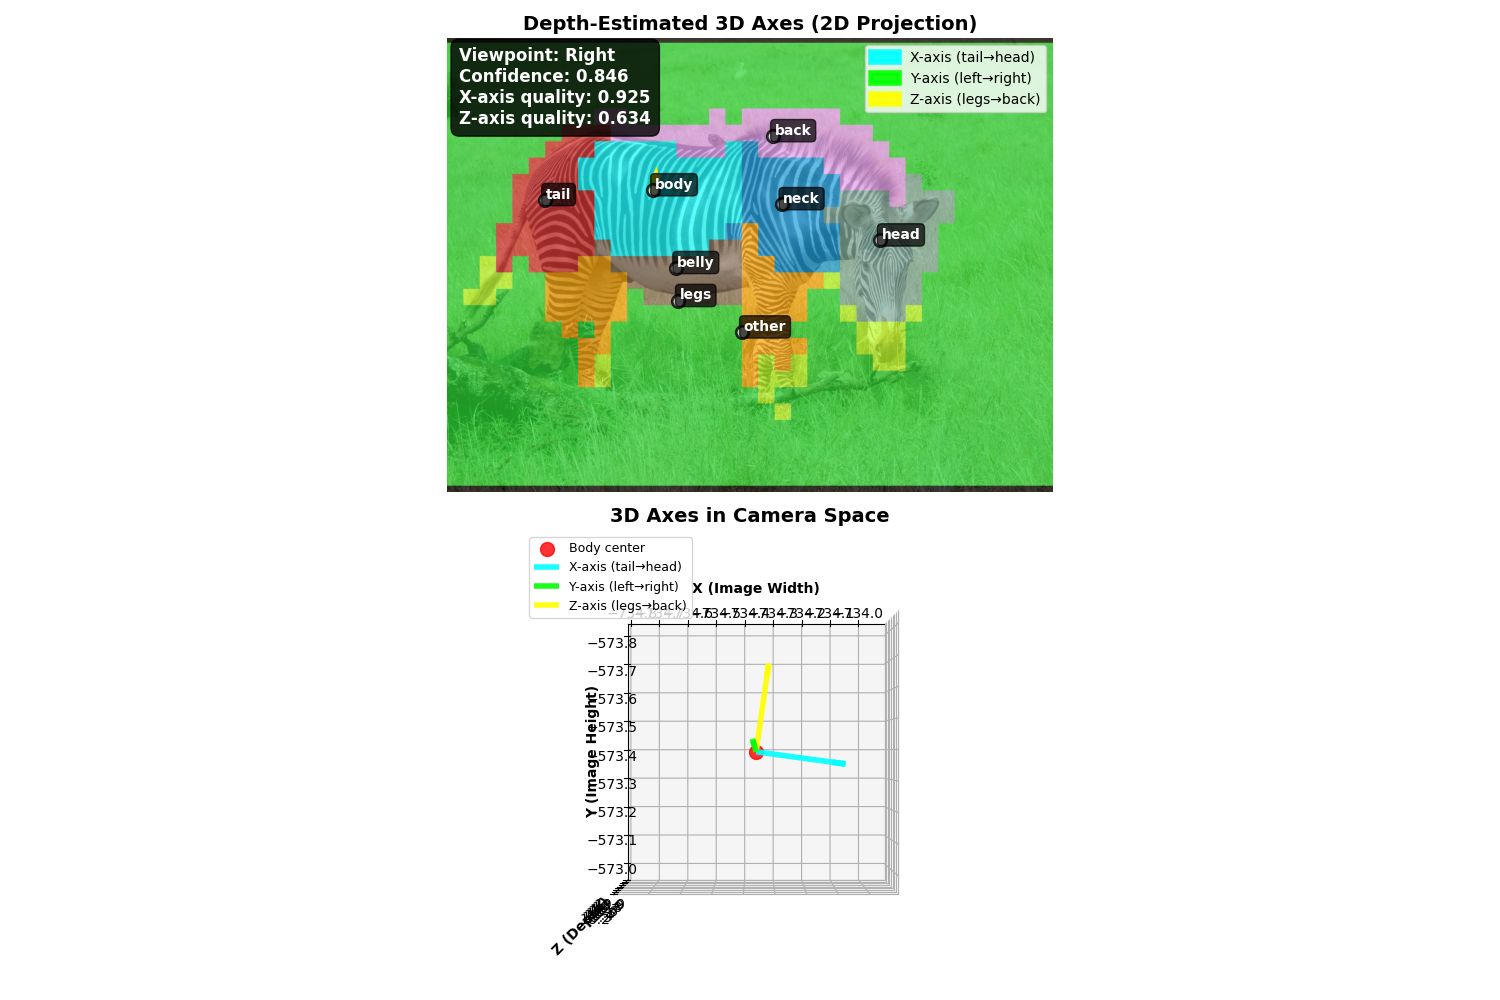

In [22]:
 # Import the new functions
# from viewpoint_3d import estimate_viewpoint_with_axis_fitting
from src.visualization.depth_visualization import visualize_depth_estimated_axes    


# annotation = annotations[20]
# annotation = [a for a in annotations if "CT185-465_IMG_0835.JPG" in str(a.image_path)]
# image = Image.open("../../CT185-465_IMG_0835.JPG")

image = detection_results[3]['image']
patch_features, patch_coordinates, actual_relative_patch_size, depthmap = depth_extractor.extract_patch_features_with_depth(image)
patch_depths = aggregate_depth_to_patches(depthmap, patch_coordinates, actual_relative_patch_size, 'median')
        
# Transform with analysis method
raw_output = analysis_method.transform(patch_features)
if raw_output.ndim == 1:
    patch_components = np.zeros((len(raw_output), n_clusters))
    patch_components[np.arange(len(raw_output)), raw_output] = 1.0
else:
    patch_components = raw_output

# Run the enhanced viewpoint estimation
estimation_result = estimate_viewpoint_with_axis_fitting(
    patch_components=patch_components,
    patch_coordinates=patch_coordinates,
    patch_depths=patch_depths,  # From DINOv2 depth extraction
    relative_patch_size=actual_relative_patch_size,
    cluster_labels=cluster_labels,  # body part labels
    image_size=image.size,
    depth_mult=50,
    morphology=False,
    # operations=["opening"],
    kernel_shape="disk",
    kernel_size=1
)

# test_labels = {
#  'background': [0, 29, 1,5, 19,20, 24,25,
#   2,
#   3,
#   4,
#   6,
#   7,
#   8,
#   9,
#   10,
#   11,
#   12,
#   13,
#   14,
#   15,
#   16,
#   18,
#   21,
#   22,
#   23,
#   26,
#   27,
#   28],
#  'head': [17],}

# Visualize the results
fig = visualize_depth_estimated_axes(
    image=image,
    estimation_result=estimation_result,
    patch_coordinates=patch_coordinates,
    patch_depths=patch_depths,
    patch_components=patch_components,
    cluster_labels=cluster_labels,
    relative_patch_size=actual_relative_patch_size,
    show_3d_view=True,  # Shows both 2D projection and 3D view
    axis_scale=100.0    # Adjust arrow length
)
print("=== DEPTH DEBUGGING ===")
print(f"Depth shape: {patch_depths.shape}")
print(f"Depth stats: min={patch_depths.min():.3f}, max={patch_depths.max():.3f}, mean={patch_depths.mean():.3f}")
print(f"Depth unique values: {len(np.unique(patch_depths))} unique values")
print(f"Are all depths the same? {np.allclose(patch_depths, patch_depths[0])}")

# Also check if depth is correlated with patch position


# Print detailed results
print(f"Viewpoint: {estimation_result['viewpoint']}")
print(f"Confidence: {estimation_result['confidence']:.3f}")
print(f"X-axis quality: {estimation_result['x_quality']:.3f}")
print(f"Z-axis quality: {estimation_result['z_quality']:.3f}")
print(f"Available parts: {estimation_result['available_parts']}")

print("X-axis vector:", estimation_result['axes_3d']['x'])
# print("Head centroid:", estimation_result['body_parts']['head']['centroid'])       
# print("Body centroid:", estimation_result['body_parts']['body']['centroid'])
# print("Tail centroid:", estimation_result['body_parts']['tail']['centroid'])

In [ ]:
plt.figure()
plt.imshow(image)
plt.show()